In [13]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
mkdir /root/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
!cp kaggle.json /root/.kaggle/kaggle.json

In [16]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!rm -rf chest_xray/__MACOSX
!rm -rf chest_xray/chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0450-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0451-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0452-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0453-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0453-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0455-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0456-0001

# Loading Datasets into memory & Visualize Distributions

In [17]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from imutils import paths
from sklearn.model_selection import train_test_split


def generate_dataframe(directory):
  img_paths=list(paths.list_images(directory))
  labels=['normal' if x.find('NORMAL') > -1 else 'pn' for x in img_paths]
  return pd.DataFrame({'paths': img_paths, 'labels':labels})


all_df=generate_dataframe('chest_xray')

train,test=train_test_split(all_df,test_size=0.2,random_state=42)

print(train['labels'].value_counts())
print(test['labels'].value_counts())



pn        3434
normal    1250
Name: labels, dtype: int64
pn        839
normal    333
Name: labels, dtype: int64


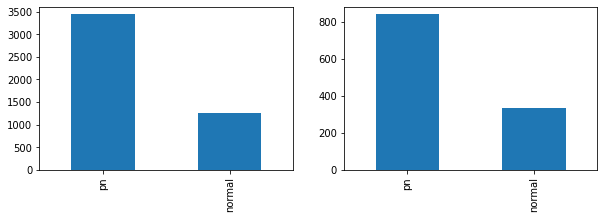

In [18]:
fig=plt.figure(figsize=(10,3))
for idx, x in enumerate([train,test]):
  fig.add_subplot(1,2,idx+1)
  x['labels'].value_counts().plot(kind='bar')

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
def create_generators(train,test,size=224,b=32):
  train_generator=ImageDataGenerator(
      rescale=1./255, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, validation_split=0.2)
  test_generator=ImageDataGenerator(rescale=1./255)

  baseargs={
      "x_col":'paths',
      "y_col":'labels',
      "class_labels":['normal','pn'],
      "class_mode":'binary',
      "target_size":(size,size),
      "batch_size":b,
      "seed":42
  }

  train_generator_flow=train_generator.flow_from_dataframe(
      **baseargs,
      dataframe=train,
      subset='training' 
  )
  validation_generator_flow=train_generator.flow_from_dataframe(
      **baseargs,
      dataframe=train,
      subset='validation'
  )
  test_generator_flow=test_generator.flow_from_dataframe(
      **baseargs,
      dataframe=test,
      shuffle=False
  )

  return train_generator_flow,validation_generator_flow,test_generator_flow
  



Found 3748 validated image filenames belonging to 2 classes.
Found 936 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


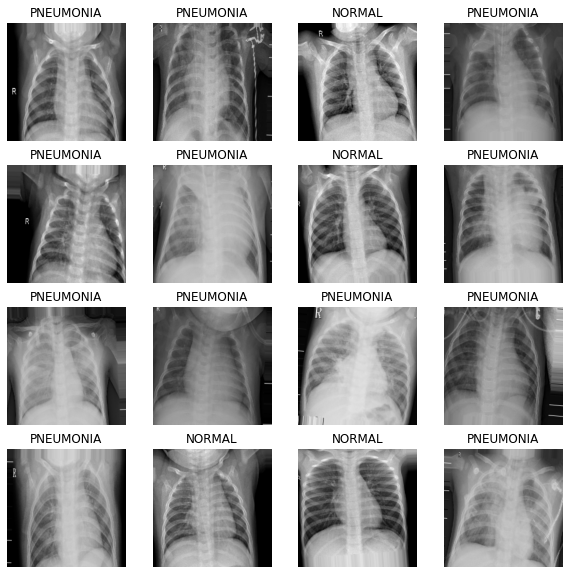

In [22]:
train_generator,validation_generator,test_generator=create_generators(train,test,224,32)

imgs=train_generator.next()
fig=plt.figure(figsize=(10,10))

for i in range(16):
  fig.add_subplot(4,4,i+1)
  image=imgs[0][i]
  label='PNEUMONIA' if imgs[1][i]==1 else 'NORMAL'
  plt.axis('off')
  plt.imshow(image)
  plt.title(label)

# Defining Networks (SmallNet and VGG16)


In [23]:
#some standard imports
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense, Conv2D, MaxPooling2D, Flatten,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,TensorBoard,EarlyStopping
from tensorflow.keras.metrics import Recall,Precision,AUC
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model

from datetime import datetime

In [24]:
def make_smallnet():
  SIZE=224
  model=Sequential()
  model.add(Conv2D(32,(3,3),activation='relu',input_shape=(SIZE,SIZE,3)))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(64,(3,3),activation='relu'))

  model.add(Flatten())
  model.add(Dense(64,activation='relu'))
  model.add(Dense(1,activation="sigmoid"))

  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(name='recall'),Precision(name='precision'),AUC(name='auc')])

  return model
  

In [25]:
def make_VGGnet():
  SIZE=224
  m=VGG16(weights='imagenet',include_top=False, input_shape=(SIZE,SIZE,3))

  for layer in m.layers:
    layer.trainable=False

    x=Flatten()(m.output)
    x=Dense(4096,activation='relu')(x)
    x=Dense(1072,activation='relu')(x)
    x=Dropout(0.2)(x)
    predictions=Dense(1,activation="sigmoid")(x)

    model=Model(inputs=m.input,outputs=predictions)

    #Compile and run

    adam=Adam(learning_rate=0.001)
    model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy',Recall(name='recall'),Precision(name='precision'),AUC(name='auc')])

    return model